---

# Practical Machine Learning with Python

## Guillermo Avendaño-Franco 

### HPC Summer Workshop 2019

---

This material was elaborated from a variety of sources, mostly other notebooks on Internet.

A list of the most relevant sources for this notebook are:

 1. A class in Machine Learning at University of Turin. The original autors were Dr. Ciro Cattuto, Dr. Laetitia Gauvin and Dr. André Panisson. The material was adapted to fit the delivery format of a workshop on Practical Machine Learning on Python for graduate students and Faculty at West Virginia University. The original notebooks can be downloaded from [Rugantio Costa's Github Repository](https://github.com/rugantio/MachineLearningCourse.git)

 2. An introduction to Machine Learning from Yale Digital Humanities Lab, a series of notebooks can be found at:
    <https://github.com/YaleDHLab/lab-workshops.git>
    
 3. The notebooks from Aurelien Geron author of Hands-on Machine Learning with Scikit-learn and TensorFlow. The notebooks are located here <https://github.com/ageron/handson-ml>

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sklearn

# Dimensionality Reduction

In machine learning is not unusual the number of features been in the order hundreds, thousands or even more. 
However, having that extra data is not making things better, and it can surely make things worst. 

"High-dimensional" datasets can be quite hard to work with and reason about. High dimensional datasets also pose specific challenges to many machine learning models (see **[The Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)**). To work around these challenges, it's often helpful to reduce the number of dimensions required to express a given dataset. That reduction is trying to solve two problems. The dimensionality reduction itself and the focus on more relevant features that maximize the probability of successful 
classifications.

## Principal Component Analysis

One popular way to reduce the dimensionality of a dataset is to use a technique called [**Principal Component Analysis**](https://en.wikipedia.org/wiki/Principal_component_analysis). PCA tries to find a lower dimensional representation of a dataset by projecting that dataset down into a smaller dimensional space in a way that minimizes loss of information.

To get an intuition about PCA, suppose you have points in two dimensions, and you wish to reduce the dimensionality of your dataset to a single dimension. To do so, you could find the center of the points then create a line $L$ with a random orientation that passes through that center. One can then project each point onto $L$ such that an imaginary line between the point and $L$ form a right angle. Within this "projection", each 2D point can be represented with just its position along the 1D $L$, effectively giving us a 1D representation of the point's position in its original space. Furthermore, we can use the difference between the largest and smallest values of points projected onto $L$ as a measure of the amount of "variance" or "spread" within the data captured in $L$&mdash;the greater this spread, the greater the amount of "signal" from the original dataset is represented in the projection.

If one were to slowly rotate $L$ and continue measuring the delta between the greatest and smallest values on $L$ at each orientation, one could find the orientation of the projection line that minimizes information loss. (This line of minimal information loss is shown in pink below.) Once that line is discovered, we can actually project all of our points onto that lower-dimensional embedding (see the red points below when the black line is colinear with the pink line):

<img src='fig/pca.gif'>





For a beginner-friendly deep dive into the mechanics behind this form of dimension reduction, check out Josh Starmer's [step-by-step guide to PCA](https://www.youtube.com/watch?v=FgakZw6K1QQ).


PCA (Principal Component Analysis) converts a dataset of possibly correlated features into a dataset of linearly uncorrelated features called principal components. is equivalent to **Singular Value Decomposition** (SVD):

$$\mathbf{X} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^*$$

Formally, the singular value decomposition of an $m \times n$ real or complex matrix $\mathbf{M}$ is a factorization of the form $\mathbf{U\Sigma V^*}$, where $\mathbf{U}$ is an $m \times m$ real or complex **unitary matrix**, $\mathbf{\Sigma}$ is an $m \times n$ **rectangular diagonal matrix** with non-negative real numbers on the diagonal, and $\mathbf{V}$ is an $n \times n$ real or complex unitary matrix. The diagonal entries $\sigma_i$ of $\mathbf{\Sigma}$ are known as the **singular values** of $\mathbf{M}$. The columns of $\mathbf{U}$ and the columns of $\mathbf{V}$ are called the **left-singular vectors** and **right-singular vectors** of $\mathbf{M}$, respectively.

<img src="fig/1280px-Singular_value_decomposition_visualisation.svg.png" alt="SVD" style="width:400px">

For Real-valued matrices the conjugate transpose $\mathbf{V}^*$ becomes just the transpose $\mathbf{V}^T$ and the decomposition is:

$$\mathbf{X} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^T$$

The value returned from `transform` is in fact the matrix $\mathbf{U}$. The parameter `n_components` is the number of components to keep. if `n_components` is not set, all components are kept; it means that the result of `transform` is a matrix $n \times n$ (if $d \geq n$) or $n \times d$ (if $d < n$).

The values in the attribute `explained_variance_` are related to $\boldsymbol{\Sigma}$ in the SVD decomposition. Finally, the values in the attribute `components_` are related to $\mathbf{V}^T$.

The optional parameter `whiten=True` make it possible to project the data onto the singular space while scaling each component to unit variance. This is often useful if the models down-stream make strong assumptions on the isotropy of the signal: this is for example the case for Support Vector Machines with the RBF kernel and the K-Means clustering algorithm.

# Dimensionality reduction of MNIST dataset

The MNIST dataset contains 70000 images of hand-written digits. Each image is a matrix of 28x28 grayscale pixels. The value of each pixel goes from 0 to 255.

There is more information available in the MNIST dataset repository:
http://yann.lecun.com/exdb/mnist/

Let's first fetch the dataset from the internet (which may take a while, note the asterisk [*]):

In [2]:
from sklearn.datasets import fetch_openml
X_all, y_all = fetch_openml('mnist_784', version=1, return_X_y=True)

# The shape of input and labels
print(X_all.shape)
print(y_all.shape)

(70000, 784)
(70000,)


This dataset is ordered, and we will get just part of it to speed up this exercise.

For this, we need to shuffle the entire data and get the first instances.

In [3]:
from sklearn.utils import shuffle

# shuffle dataset (which is sorted!)
X_all, y_all = shuffle(X_all, y_all, random_state=42)

# take only the first instances, to shorten runtime
X = X_all[:1500]
y = y_all[:1500]

# take the other instances for testing
X_test = X_all[1500:]
y_test = y_all[1500:]

From the sklearn documentation:

> Many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the l1 and l2 regularizers of linear models) assume that all features are centered around zero and have variance in the same order. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

We will then rescale the training data, since this is important to improve the performance of the classification algorithm that we will use later.

In [4]:
# Rescale grayscale from -1 to 1
X = X/255.0*2 - 1

Let's have a look at some of the instances in the dataset we just loaded:

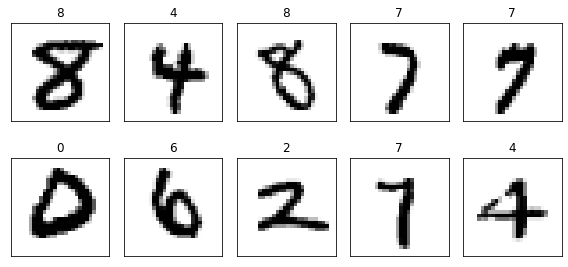

In [5]:
plt.rc("image", cmap="binary")
plt.figure(figsize=(8,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X[i].reshape(28,28))
    plt.title(y[i])
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)

pca.fit(X)

U = pca.transform(X)
S = pca.explained_variance_
V = pca.components_

print (U.shape)
print (S.shape)
print (V.shape)

(1500, 2)
(2,)
(2, 784)


## PCA using SVD decomposition

The PCA can be obtained from Numpy function `linalg.svg` in that case the X values must be centered, something that the PCA function in Scikit-learn does for you

In [7]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [8]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [9]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [10]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [11]:
X2D_using_svd = X2D

In [12]:
X2D = pca.fit_transform(X)

In [13]:
print(X2D.shape)
X2D[:5]

(1500, 2)


array([[ 6.07874971,  4.11878295],
       [-1.96209544, -4.07737107],
       [-0.68516646,  0.66131667],
       [-3.90472521, -2.94240724],
       [-3.47799664, -2.43585472]])

In [14]:
print(X2D_using_svd.shape)
X2D_using_svd[:5]

(1500, 2)


array([[-6.07877132,  4.11830917],
       [ 1.9620494 , -4.07694401],
       [ 0.68517622,  0.66101962],
       [ 3.90475013, -2.94237969],
       [ 3.47801914, -2.43581028]])

Notice that running PCA multiple times on slightly different datasets may result in different results. In general the only difference is that some axes may be flipped. In this example, PCA using Scikit-Learn gives the same projection as the one given by the SVD approach, except both axes are flipped

## Measuring the data loss from using a PCA

As we are using just 2 dimensions out of the 768 orginal ones. It is clear that we have to pay a price for that.
We can quantify the loss from the PCA like this:

First, we recover the 3D points projected on the plane (PCA 2D subspace).

In [15]:
X3D_inv = pca.inverse_transform(X2D)

The recovered 3D points are not exactly equal to the original 3D points:

In [16]:
np.allclose(X3D_inv, X)

False

The reconstruction error can be computed by taking the average in the difference between the recreated images and the original ones.

In [17]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

176.61855162456868

Quite a big difference, so the question is: How many components should be good enough? How to quantify "good enough"?
To answer those questions lets first get a visual idea about the transformations involved here.

## Visualizing the transformations

The first row in the figure below shows the first digits on the MNIST database, the second row the back transformed images using just 2 Principal Components.

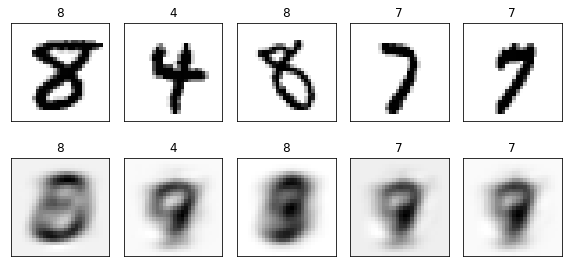

In [18]:
plt.rc("image", cmap="binary")
plt.figure(figsize=(8,4))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(X[i].reshape(28,28))
    plt.title(y[i])
    plt.xticks(())
    plt.yticks(())
for i in range(5):
    plt.subplot(2,5,5+i+1)
    plt.imshow(X3D_inv[i].reshape(28,28))
    plt.title(y[i])
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()

The transformed images look noisy, that is because from the 768 pixels we have reduced to just 2, considering that is remarkable that we still see a resemblance of the original digit on the 

Now let's have a look at the most important directions on which the dataset was projected. These directions can be accessed in the $\mathbf{V}^T$ matrix. For doing that we need to construct PCA for all components.

In [19]:
pca_complete = PCA()

pca_complete.fit(X)

Uc = pca_complete.transform(X)
Sc = pca_complete.explained_variance_
Vc = pca_complete.components_

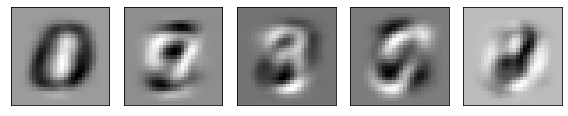

In [20]:
plt.figure(figsize=(8,6))

for i in range(5): # loop over all means
    plt.subplot(1,5,i+1)
    plt.imshow(Vc[i].reshape(28,28))
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()

The figures above are just 2D representations of vectors in a 768 dimensional space. They are not mean to be numbers but capture the combination of pixels that maximize the variance in the set.

The later directions (here, from the 100-th on) show noise and small variations between different, but very similar training instances:

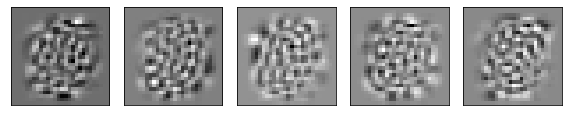

In [21]:
plt.figure(figsize=(8,4))

for i in range(5): # loop over all means
    plt.subplot(1,5,i+1)
    plt.imshow(Vc[100+i].reshape(28,28))
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()

## Selecting the right number of components

The number of "interesting" dimensions can be seen from the importance of the found directions.

We can find this information by plotting the `explained_variance_` attribute from the `PCA` variable. This is related to the $\Sigma$ matrix in the following way:

$$\mathbf{ev} = \frac{1}{N} \Sigma^2 $$

In order to find the most relevant directions, we can use the `explained_variance_` to get 90% of the dataset variance.

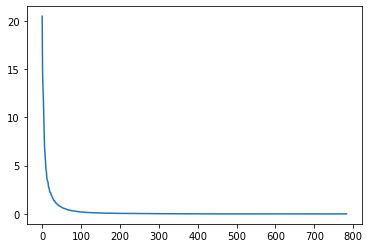

In [22]:
plt.plot(pca_complete.explained_variance_);

80


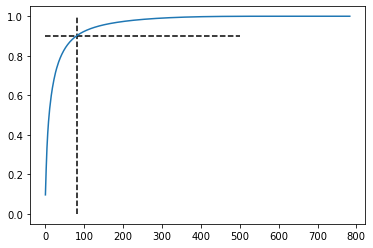

In [23]:
ev_cumsum = np.cumsum(pca_complete.explained_variance_)/(pca_complete.explained_variance_).sum()
ev_at90 = ev_cumsum[ev_cumsum<0.9].shape[0]
print (ev_at90)

plt.plot(ev_cumsum)
plt.vlines(ev_at90, 0, 1, linestyles='dashed')
plt.hlines(0.9, 0, 500, linestyles='dashed');

We can see that the intrinsic dimensionality is not higher than 80, even though the dataset has 784 dimensions.

We can explain that number intuitively, notice that the digits rarely touch the four corners of the picture, leaving many of those pixels zeroed and not adding information to the figure. the center and circular areas around the center provides most of the information about the digits. That is why the first PCA components put special emphasis on them.



We can see that the intrinsic dimensionality is not higher than 80, even though the dataset has 784 dimensions.

We can explain that number intuitively, notice that the digits rarely touch the four corners of the picture, leaving many of those pixels zeroed and not adding information to the figure. the center and circular areas around the center provides most of the information about the digits. That is why the first PCA components put special emphasis on them.

We now know that just 2 components is not enough but 80 components will account for 90% of explained variance in the data, we say that $\mathbf{k_p}$ is the number of components to achieve $p$ % of explained variance.

By setting the parameter `n_components` to $\mathbf{k}$, we limit the number of components to $\mathbf{k}$. At this point, the decomposition is a **Truncated SVD**.

As consequence, the value returned from `transform` is in fact a matrix $\mathbf{U} \in \mathbb{R}^{n \times k}$, where n is the number of samples and k is the number of components. The number of values in the attribute `explained_variance_`, related to $\boldsymbol{\Sigma}$ in the SVD decomposition, is $\mathbf{k}$. Finally, the values in the attribute `components_` are a matrix $\mathbf{V}^T \in \mathbb{R}^{k \times m}$, where $m$ is the number of features.

In [24]:
from sklearn.decomposition import PCA
pca = PCA(80)

pca.fit(X)

U = pca.transform(X)
S = pca.explained_variance_
V = pca.components_

print (U.shape)
print (S.shape)
print (V.shape)

(1500, 80)
(80,)
(80, 784)


Now, lets have a look to the digits when 80 components are used.

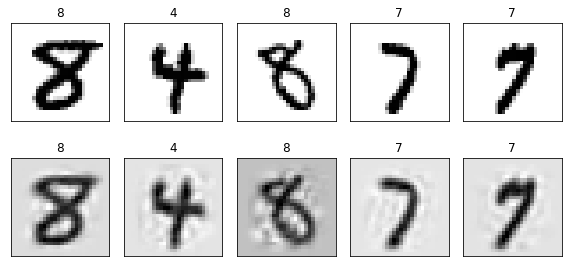

In [25]:
X2D = pca.fit_transform(X)
X3D_inv = pca.inverse_transform(X2D)

plt.rc("image", cmap="binary")
plt.figure(figsize=(8,4))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(X[i].reshape(28,28))
    plt.title(y[i])
    plt.xticks(())
    plt.yticks(())
for i in range(5):
    plt.subplot(2,5,5+i+1)
    plt.imshow(X3D_inv[i].reshape(28,28))
    plt.title(y[i])
    plt.xticks(())
    plt.yticks(())
plt.tight_layout()

Notice that the 5 digits from the first row are created from 768 components and the figures on the second row were back converted from the PCA with just 80 components.